Importing required libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

import joblib

Defining parameters

In [9]:
train_dir = "Train"
test_dir = "Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64
EPOCHS = 1
LR =  0.00003
NUM_CLASSES = 13
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting','RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']

Creating an image data generator class object

In [11]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_fun
                                 )

Applying it to the dataset

In [12]:

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical"
                                                   )
test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical"
                                                  )

Found 318436 images belonging to 13 classes.
Found 46356 images belonging to 13 classes.


The model

In [17]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet121(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer='Adam', 
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC()])
  
    return model

model = define_compile_model()

Fitting the model 

In [18]:
history=model.fit(x = train_generator,validation_data=test_generator,epochs = EPOCHS)

4978/4978 [==============================] - 6317s 1s/step - loss: 2.8584 - auc: 0.5496 - val_loss: 2.7574 - val_auc: 0.4660


In [19]:
joblib.dump(model,'trainedModel2.pkl')

['trainedModel2.pkl']

Testing with a sample video

In [9]:
import cv2
cam = cv2.VideoCapture("viral-video-cctv-footage-of-man-attacking-police-officer-shorts-trending-viralvideo-720-ytshorts.savetube.me.mp4")
currentframe = 0
  
while(True):
      
    # reading from frame
    ret,frame = cam.read()
  
    if ret:
        if currentframe%10==0:
                # if video is still left continue creating images
                name = './newTrain/' + str(currentframe) + '.png'
                print ('Creating...' + name)
        
                # writing the extracted images
                cv2.imwrite(name, frame)
        
                # increasing counter so that it will
                # show how many frames are created
        currentframe += 1
    else:
        break
  
# Release all space and windows once done
cam.release()
cv2.destroyAllWindows()

Creating..../newTrain/0.png
Creating..../newTrain/10.png
Creating..../newTrain/20.png
Creating..../newTrain/30.png
Creating..../newTrain/40.png
Creating..../newTrain/50.png
Creating..../newTrain/60.png
Creating..../newTrain/70.png
Creating..../newTrain/80.png
Creating..../newTrain/90.png
Creating..../newTrain/100.png
Creating..../newTrain/110.png
Creating..../newTrain/120.png
Creating..../newTrain/130.png
Creating..../newTrain/140.png
Creating..../newTrain/150.png
Creating..../newTrain/160.png
Creating..../newTrain/170.png
Creating..../newTrain/180.png
Creating..../newTrain/190.png
Creating..../newTrain/200.png
Creating..../newTrain/210.png
Creating..../newTrain/220.png
Creating..../newTrain/230.png
Creating..../newTrain/240.png
Creating..../newTrain/250.png
Creating..../newTrain/260.png
Creating..../newTrain/270.png
Creating..../newTrain/280.png
Creating..../newTrain/290.png
Creating..../newTrain/300.png
Creating..../newTrain/310.png
Creating..../newTrain/320.png
Creating..../newTrain

In [26]:
test_datagen = ImageDataGenerator(rescale = 1./25)

In [28]:
newTest='newTrain'
test = test_datagen.flow_from_directory(directory =newTest)

Found 90 images belonging to 1 classes.


In [5]:
newModel=joblib.load("trainedModel.pkl")

In [9]:
newModel.evaluate(test_generator,batch_size=BATCH_SIZE)

1740/1740 [==============================] - 646s 370ms/step - loss: 1.7083 - auc: 0.8316


[1.7082630395889282, 0.8316051959991455]

In [29]:
pred=model.predict(test)

3/3 [==============================] - 5s 1s/step


In [31]:
a=set()
for i in pred:
    a.add(CLASS_LABELS[list(i).index(max(i))])
print(a)

{'Stealing'}


ROC AUC Score

725/725 [==============================] - 218s 301ms/step
ROC AUC score: 0.4660262121696569


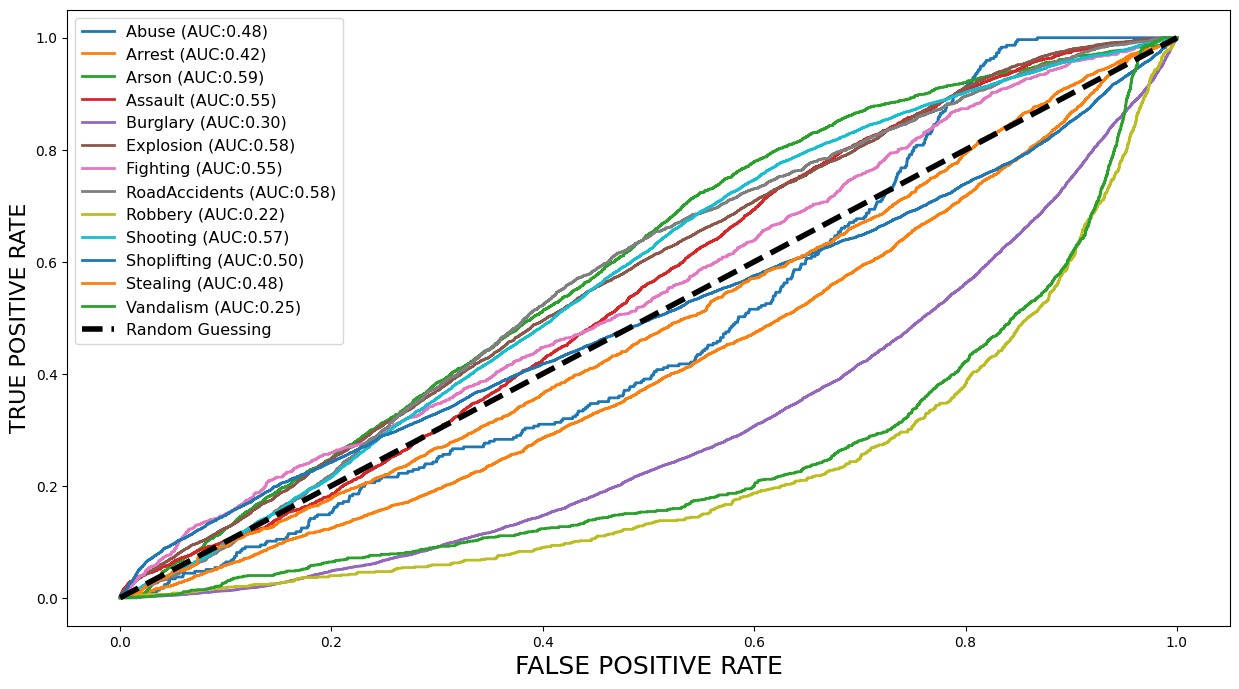

In [33]:
preds = model.predict(test_generator)
y_test = test_generator.classes
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [2]:
from os import listdir
import os
import shutil

In [6]:
folder=listdir(path="Test")
frames=[]
features=[]
for i in folder:
    subfolder=listdir("Test/"+i)
    new=subfolder[0][0:-11]
    path=os.path.join("Test/"+i,new)
    os.mkdir(path)
    for j in subfolder:
        if new not in j:
            new=j[0:-11]
            path=os.path.join("Test/"+i,new)
            os.mkdir(path)
            shutil.move("Test/"+i+"/"+j,path)
        else:
            shutil.move("Test/"+i+"/"+j,path)
    # if i[0:14] != new:
    #     new=i[0:14]
    #     frames=[]
    #     features.append(frames)
    # else:
    #     frames.append()
        